# APT Bridge (CDP <-> APT Bridge <-> Secondary Market)

RAI Project

BlockScience

November 18 2020



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from pprint import pprint
import matplotlib.pyplot as plt
import math, statistics
from functools import partial
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import root, show_options, newton
import numpy as np
import seaborn as sns
import pickle

plt.rcParams['figure.figsize'] = [10, 5]

/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
debt_market_df = pd.read_csv('market_model/data/debt_market_df.csv', index_col='date', parse_dates=True)
market_price = pd.DataFrame(debt_market_df['p'])
eth_price = pd.DataFrame(debt_market_df['rho_star'])
    
market_returns = ((market_price - market_price.shift(1))/market_price).to_numpy().flatten()
market_gross_returns = (market_price / market_price.shift(1)).to_numpy().flatten()

eth_returns = ((eth_price - eth_price.shift(1))/eth_price).to_numpy().flatten()
eth_gross_returns = (eth_price / eth_price.shift(1)).to_numpy().flatten()

debt_market_df['market_returns'] = market_returns
    
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']
indep_vars = debt_market_df[features]

In [3]:
model = pickle.load(open('models/pickles/apt_debt_model_2020-11-12.pickle', 'rb'))
independent_vars = debt_market_df[features].to_numpy()
full_prediction = model.predict(independent_vars)

In [4]:
X_f = sm.add_constant(full_prediction)
debOLS = sm.OLS(market_price, X_f)
debres = debOLS.fit()
print(debres.summary())
#debres.save('apt_debt_market.pickle')

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     2646.
Date:                Wed, 18 Nov 2020   Prob (F-statistic):          2.42e-231
Time:                        15:08:41   Log-Likelihood:                 2410.5
No. Observations:                 652   AIC:                            -4817.
Df Residuals:                     650   BIC:                            -4808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1595      0.023     -7.072      0.0

In [5]:
alpha_0 = debres.params[0]; alpha_1 = debres.params[1]
print('alpha_0: {}, alpha_1: {}'.format(alpha_0, alpha_1))

alpha_0: -0.15945516088407055, alpha_1: 1.159513245269044


In [6]:
# OLS Estimate of AR(1) + ETH Regression -- consistent but biased
eth_p = eth_price.to_numpy().flatten()
eth_p_mean = np.mean(eth_p)
mar_p = market_price.to_numpy().flatten()
mar_p_mean = np.mean(mar_p)
X_p = np.stack((np.roll(mar_p,1)[1:] - mar_p_mean,eth_p[1:] - eth_p_mean))
X_p = sm.add_constant(X_p.T)
pOLS = sm.OLS(mar_p[1:], X_p, missing='drop')
pres = pOLS.fit()
print(pres.summary())
# pres.save('apt_price_generation.pickle')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     311.3
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           1.78e-95
Time:                        15:08:41   Log-Likelihood:                 2097.8
No. Observations:                 651   AIC:                            -4190.
Df Residuals:                     648   BIC:                            -4176.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0004      0.000   2640.351      0.0

In [7]:
# Maximum Likelihood Estimate of AR(1) + ETH Regression -- unbiased, poss. less efficient
mar_p_zeroed = mar_p - mar_p_mean
eth_p_zeroed = eth_p - eth_p_mean
autoMod = AutoReg(mar_p_zeroed, 1, exog = eth_p_zeroed)
autores = autoMod.fit()
print(autores.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  652
Model:                   AutoReg-X(1)   Log Likelihood                2097.776
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Wed, 18 Nov 2020   AIC                             -9.270
Time:                        15:08:41   BIC                             -9.243
Sample:                             1   HQIC                            -9.260
                                  652                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.724e-05      0.000     -0.046      0.964      -0.001       0.001
y.L1           0.6756      0.029     23.415      0.000       0.619       0.732
x1          3.868e-06   1.42e-06      2.729      0.0

/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [8]:
beta_0 = pres.params[0]; beta_1 = pres.params[1]; beta_2 = pres.params[2]
print('beta_0: {}, beta_1: {}, beta_2: {}'.format(beta_0, beta_1, beta_2))

beta_0: 1.0003953223600617, beta_1: 0.6756295152422528, beta_2: 3.86810578185312e-06


In [9]:
# Prediction of market price from CDP factors as an OLS regression
X_d = sm.add_constant(indep_vars)
dpOLS = sm.OLS(market_price, X_d)
dpres = dpOLS.fit()
print(dpres.summary())
# dpres.save('debt_market_OLS_model.pickle')

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     44.17
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           8.64e-76
Time:                        15:08:41   Log-Likelihood:                 2078.1
No. Observations:                 652   AIC:                            -4130.
Df Residuals:                     639   BIC:                            -4072.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0101      0.001    719.758      0.0

In [10]:
# ML debt model root function
def G(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    return err

In [11]:
# OLS debt model root function
def G_OLS(x, to_opt, data, constant):
    for i,y in enumerate(x):
        #print(x)
        data[:,to_opt[i]] = y
    err = dpres.predict(data)[0] - constant
    return err

In [12]:
# Decide whether to use 1) the ML root function or the OLS function, and
# 2) historical market price data or endogenous data
use_ML_model = False
use_historical_price = False

In [13]:
# Decide upon external handler for passing/receiving values to/from CDP
handle_external = False

In [14]:
# Select ML or OLS root function
if use_ML_model:
        func = G
else:
        func = G_OLS

In [15]:
# Initialize parameters, storage for root search
num_above = 0; num_below = 0
p = mar_p[0]
interest_rate = 1.01 # note gross interest rate
p_calc = np.zeros(len(market_price.index))
feature_0 = np.reshape(independent_vars[0], (-1,15)).copy()
solution = {}

# Root-finding loop
for t in range(1, len(market_price.index)):
#for t in range(1,2):

    print('iteration: ', t)
    
    # need to adjust here if using OLS results instead of ML
    if not use_ML_model:
        # add regression constant
        feature_0 = np.insert(feature_0, 0, 1, axis=1)
    
    # assign CDP levers in response to disequilibrium
    # remember: unexpected realized ETH price increase *lowers* expected return!
    if eth_returns[t] < np.mean(eth_returns[1:]):
        num_below += 1
        # mint new RAI, sell on secondary market
        optvars = ['u_1', 'v_1', 'v_2 + v_3']
    else:
        num_above += 1
        # repay RAI, buy on secondary market
        optvars = ['u_2', 'v_1', 'v_2 + v_3']
        
    # find root of non-arbitrage condition
    constant = (1/alpha_1) * (p*interest_rate + beta_2 * (eth_p_mean - eth_p[t]*interest_rate)
                                 + beta_1 * (mar_p_mean - p*interest_rate)
                ) - (alpha_0/alpha_1)
    
    optindex = [features.index(i) for i in optvars]
    
    x0 = feature_0[:,optindex][0]

    print('x0: ', x0)
    print('optvars:', optvars)
    print('constant: ', constant)
    
    try:
        x_star = newton(func, x0, args=(optindex, feature_0, constant))
        print('xstar: ' ,x_star)
        # Feasibility check, non-negativity
        if any(x_star[x_star < 0]):
            x_star = x0
    except RuntimeError as e:
        # For OLS, usually indicates non-convergence after 50 iterations (default)
        # Indicates not feasible to update CDP for this price/feature combination
        # Default to historical values here
        print('Error: {}, default to historical values...'.format(e))
        x_star = x_0
    
    optimal_values = dict((var, x_star[i]) for i, var in enumerate(optvars))
    
    if handle_external:
        # EXTERNAL HANDLER: pass optimal values to CDP handler (here, as dict)
        # EXTERNAL HANDLER: receive new initial condition from CDP handler (as numpy array)
        
        # _send_values_to_CDP(optimal_values)
        # feature_0 = _receive_values_from_CDP()
        print('external_handler')
    else:
        # INTERNAL HANDLER: reset initial condition as initial point in data set
        feature_0 = np.reshape(independent_vars[0], (-1,15)).copy()
    
    if use_historical_price:
        if t < len(market_price.index) - 1:
            p = mar_p[t]
    else:
        if handle_external:
            # EXTERNAL HANDLER: pass updated CDP features & expected price to market
            # EXTERNAL HANDLER: receive price from market (possibly with demand shock)
            # _send_feature_to_market(feature_0)
            # _send_expected_price_to_market(p)
            # p = _receive_price_from_market() 
            print('external_handler')
        else:
            # INTERNAL HANDLER: Set price as expected value
            p = constant
    
    # For diagnostics
    solution[t] = optimal_values
    p_calc[t] = constant

iteration:  1
f0: [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
  1.01000000e+02 5.95296083e+05 5.95342027e+05 1.00000000e+01
  3.59438400e+01 4.59438400e+01 0.00000000e+00 0.00000000e+00
  6.27647566e-06 2.25600637e-05 2.88365393e-05 5.95296083e+05]]
x0:  [595342.02686932   2425.662        2526.662     ]
optvars: ['u_2', 'v_1', 'v_2 + v_3']
constant:  1.0063781824911373
xstar:  [5031901.16705255   20509.40362557   21363.06629725]
iteration:  2
f0: [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
  1.01000000e+02 5.95296083e+05 5.95342027e+05 1.00000000e+01
  3.59438400e+01 4.59438400e+01 0.00000000e+00 0.00000000e+00
  6.27647566e-06 2.25600637e-05 2.88365393e-05 5.95296083e+05]]
x0:  [595296.08302933   2425.662        2526.662     ]
optvars: ['u_1', 'v_1', 'v_2 + v_3']
constant:  1.00328010580974
xstar:  [890130.58343427   3627.52187606   3778.54443688]
iteration:  3
f0: [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
  1.01000000e+02 5.9529

/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/scipy/optimize/zeros.py:445: RuntimeWarning: RMS of 7.45058e-08 reached
  warnings.warn(


['u_2', 'v_1', 'v_2 + v_3']
constant:  1.0050633866841687
xstar:  [5914993.13664759   24108.95149705   25112.43080369]
iteration:  491
f0: [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
  1.01000000e+02 5.95296083e+05 5.95342027e+05 1.00000000e+01
  3.59438400e+01 4.59438400e+01 0.00000000e+00 0.00000000e+00
  6.27647566e-06 2.25600637e-05 2.88365393e-05 5.95296083e+05]]
x0:  [595342.02686932   2425.662        2526.662     ]
optvars: ['u_2', 'v_1', 'v_2 + v_3']
constant:  1.005052803787348
xstar:  [5922101.21468362   24137.92454634   25142.60973908]
iteration:  492
f0: [[1.00000000e+00 5.00000000e-03 2.42566200e+03 2.52666200e+03
  1.01000000e+02 5.95296083e+05 5.95342027e+05 1.00000000e+01
  3.59438400e+01 4.59438400e+01 0.00000000e+00 0.00000000e+00
  6.27647566e-06 2.25600637e-05 2.88365393e-05 5.95296083e+05]]
x0:  [595296.08302933   2425.662        2526.662     ]
optvars: ['u_1', 'v_1', 'v_2 + v_3']
constant:  1.0050746014755445
xstar:  [835605.83503785   3405.25783

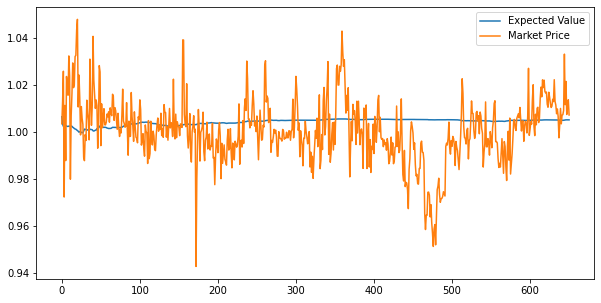

In [16]:
# Plot market price against modeled price
plt.plot(p_calc[1:], label="Expected Value")
plt.plot(mar_p[1:], label = "Market Price")
plt.legend()

In [17]:
# Get correlation coefficient of market price and calculated price
np.corrcoef(p_calc[1:], mar_p[1:])

array([[ 1.        , -0.24278328],
       [-0.24278328,  1.        ]])

0.0037714988024680576

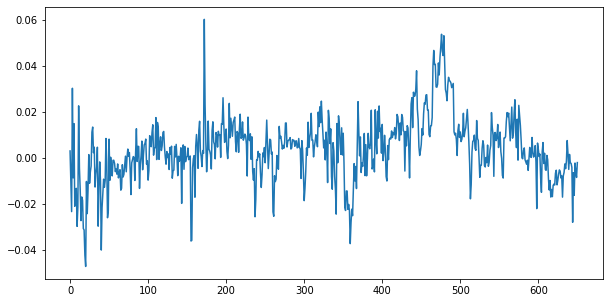

In [18]:
# Compute and plot error between market and calculated price
er = p_calc[1:] - mar_p[1:]
plt.plot(er)
np.mean(er)

293

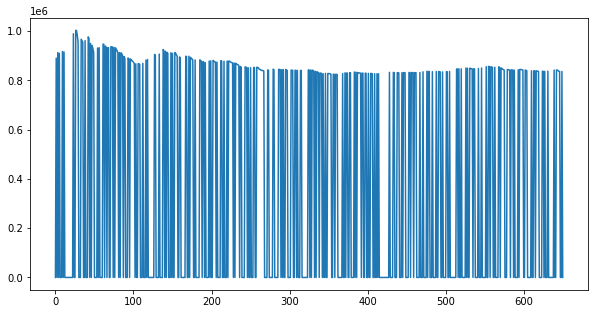

In [19]:
# quick plot of control variable solution
plt.plot([solution[i]['u_1'] if 'u_1' in solution[i] else 0 for i in solution ] )
len([solution[i]['u_1'] for i in solution if 'u_1' in solution[i] ])

21

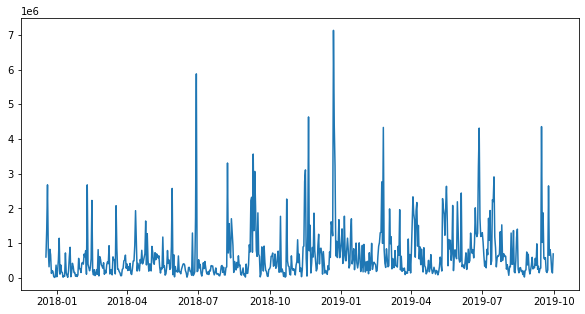

In [20]:
plt.plot(debt_market_df['u_1'])
debt_market_df[debt_market_df['u_1'] < 10000].size

In [21]:
len(eth_returns[eth_returns < np.mean(eth_returns[1:])])

293

In [22]:
print(mar_p)

[1.01760484 1.00337649 1.01297235 1.02573763 0.97222801 1.01119956
 0.9877277  1.02350915 1.01855227 1.0155477  1.03224975 1.0237282
 0.97982077 1.00683759 1.01621483 1.02927317 1.01876207 1.01987077
 1.03199189 1.03250775 1.04319496 1.04781576 1.01054043 1.02411563
 1.01439929 0.99865366 1.0107212  1.00569535 1.0031531  0.98910772
 0.98770224 0.9987751  0.99630055 1.01342076 1.00790288 1.00493256
 0.99655076 1.03089761 1.01368058 1.0027205  1.01109228 1.04057909
 1.02203    1.01613813 1.00993256 1.0135298  1.01108029 0.99300111
 1.00348269 1.02813528 1.02543685 0.99408637 1.01187658 1.0017313
 1.00513808 1.00980474 1.00295608 1.00292951 1.00414592 1.00755894
 1.0063517  1.00847593 1.00407098 1.01016601 1.00792902 1.00683667
 1.01595115 1.01514467 1.00486285 1.01024613 1.00900535 1.00492791
 1.00103549 1.00785003 1.00157718 0.99799019 1.0011412  0.99950756
 1.00720841 1.01811792 1.00449828 1.00343978 1.00191931 1.00234932
 1.01238205 1.00029401 0.99002927 1.00451229 0.99797709 0.998141